# Basic usage of `qbiome`

First, load package and some other helper packages for the analysis:

In [1]:
import qbiome
from qbiome.data_formatter import DataFormatter
from qbiome.quantizer import Quantizer
from qbiome.qnet_orchestrator import QnetOrchestrator
from qbiome.forecaster import Forecaster
from qbiome.hypothesis import Hypothesis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
plt.style.use("ggplot")

from qbiome.qutil import qsmooth

Next, we load the data. 

For this example, we use a dataset from Bokulich et. al 

- [Antibiotics, birth mode, and diet shape microbiome maturation during early life](https://doi.org/10.1126/scitranslmed.aad7121) 

The `qbiome` package includes helper methods for processing data into the correct format for Qnet construction, using the `DataFormatter()` below. If your source data is formatted differently, you may need to write your own preprocessing steps.

In [2]:
dirname = "example_data/"
data = (
    dirname + "SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_TaxaRelativeAbundance.csv"
)
meta = dirname + "SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_Characteristics.csv"
base_tax = "Class"

formatter = DataFormatter()
data = formatter.load_data(
    fpath_data=data, fpath_meta=meta, taxon_name="Class", tax_dict={}
)

There are 52 unique biomes and 1216 unique samples
There are 311 unique days
There are 99 unique weeks


Qnet construction requires the numeric data to be quantized into categorical data. Given abundance data in long-format (eg. produced by the above formatting), the `qbiome` package can quantize the data.

Data should be in the following format:

In [3]:
data

,sample_id,subject_id,variable,week,value
11,MBSMPL0020-6-10,1,Actinobacteria,27,0.366650
12,MBSMPL0020-6-10,1,Bacilli,27,0.013550
13,MBSMPL0020-6-10,1,Bacteroidia,27,0.507248
14,MBSMPL0020-6-10,1,Campylobacteria,27,0.002032
15,MBSMPL0020-6-10,1,Clostridia,27,0.035906
...,...,...,...,...,...
10233,MBSMPL0020-6-998,16,Campylobacteria,7,0.000377
10234,MBSMPL0020-6-998,16,Clostridia,7,0.155196
10235,MBSMPL0020-6-998,16,Coriobacteriia,7,0.001454
10236,MBSMPL0020-6-998,16,Fusobacteriia,7,0.143349


Then we may use `Quantizer()` methods to process the data into the correct format for fitting the qnet.

In [4]:
quantizer = Quantizer()
qnet_orchestrator = QnetOrchestrator(quantizer)

quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)

If processing your own data, you will need to generate a wide form (tabular) numpy array containing the quantized abundances for each subject (`label_matrix` - note that missing values should be filled with the empty string `''`), and the names of each variable in the data (`features`)

In [5]:
features

Index(['Actinobacteria_1', 'Actinobacteria_2', 'Actinobacteria_3',
       'Actinobacteria_5', 'Actinobacteria_6', 'Actinobacteria_7',
       'Actinobacteria_8', 'Actinobacteria_9', 'Actinobacteria_10',
       'Actinobacteria_11',
       ...
       'unclassified_Bacteria_48', 'unclassified_Bacteria_57',
       'unclassified_Bacteria_62', 'unclassified_Bacteria_79',
       'unclassified_Bacteria_80', 'unclassified_Bacteria_82',
       'unclassified_Bacteria_88', 'unclassified_Bacteria_89',
       'unclassified_Bacteria_96', 'unclassified_Bacteria_97'],
      dtype='object', length=898)

In [6]:
label_matrix

array([['A', '', 'E', ..., '', '', ''],
       ['A', '', '', ..., '', '', ''],
       ['A', '', '', ..., '', '', ''],
       ...,
       ['A', 'E', '', ..., '', 'C', ''],
       ['A', '', '', ..., '', '', ''],
       ['A', '', '', ..., '', '', '']], dtype='<U1')

In [7]:
data.week.min(), data.week.max()

(1, 98)

In [8]:
TAXA = list(data.variable.value_counts().index.values)
TAXA

['Bacilli',
 'Clostridia',
 'Actinobacteria',
 'Gammaproteobacteria',
 'Bacteroidia',
 'Negativicutes',
 'Coriobacteriia',
 'Verrucomicrobiae',
 'Desulfovibrionia',
 'Fusobacteriia',
 'Alphaproteobacteria',
 'Campylobacteria',
 'unclassified_Bacteria',
 'Vampirivibrionia',
 'Cyanobacteriia',
 'Lentisphaeria']

# Fit the qnet model

In [9]:
qnet_orchestrator.train_qnet(
    features, label_matrix, alpha=0.3, min_samples_split=2, out_fname=None
)
qnet_orchestrator.save_qnet("example_qnet.joblib")

Generate tree files to inspect model structure

In [10]:
outdirname = 'dotfiles'
import os
if not os.path.isdir(outdirname):
    os.makedirs(outdirname)
for f in os.listdir(outdirname):
    os.remove(os.path.join(outdirname, f))    
qnet_orchestrator.export_qnet_tree_dotfiles(outdirname)

! cd 'dotfiles'; for i in `ls *dot`; do dot -Tpng $i -o ${i/dot/png}; done >& /dev/null

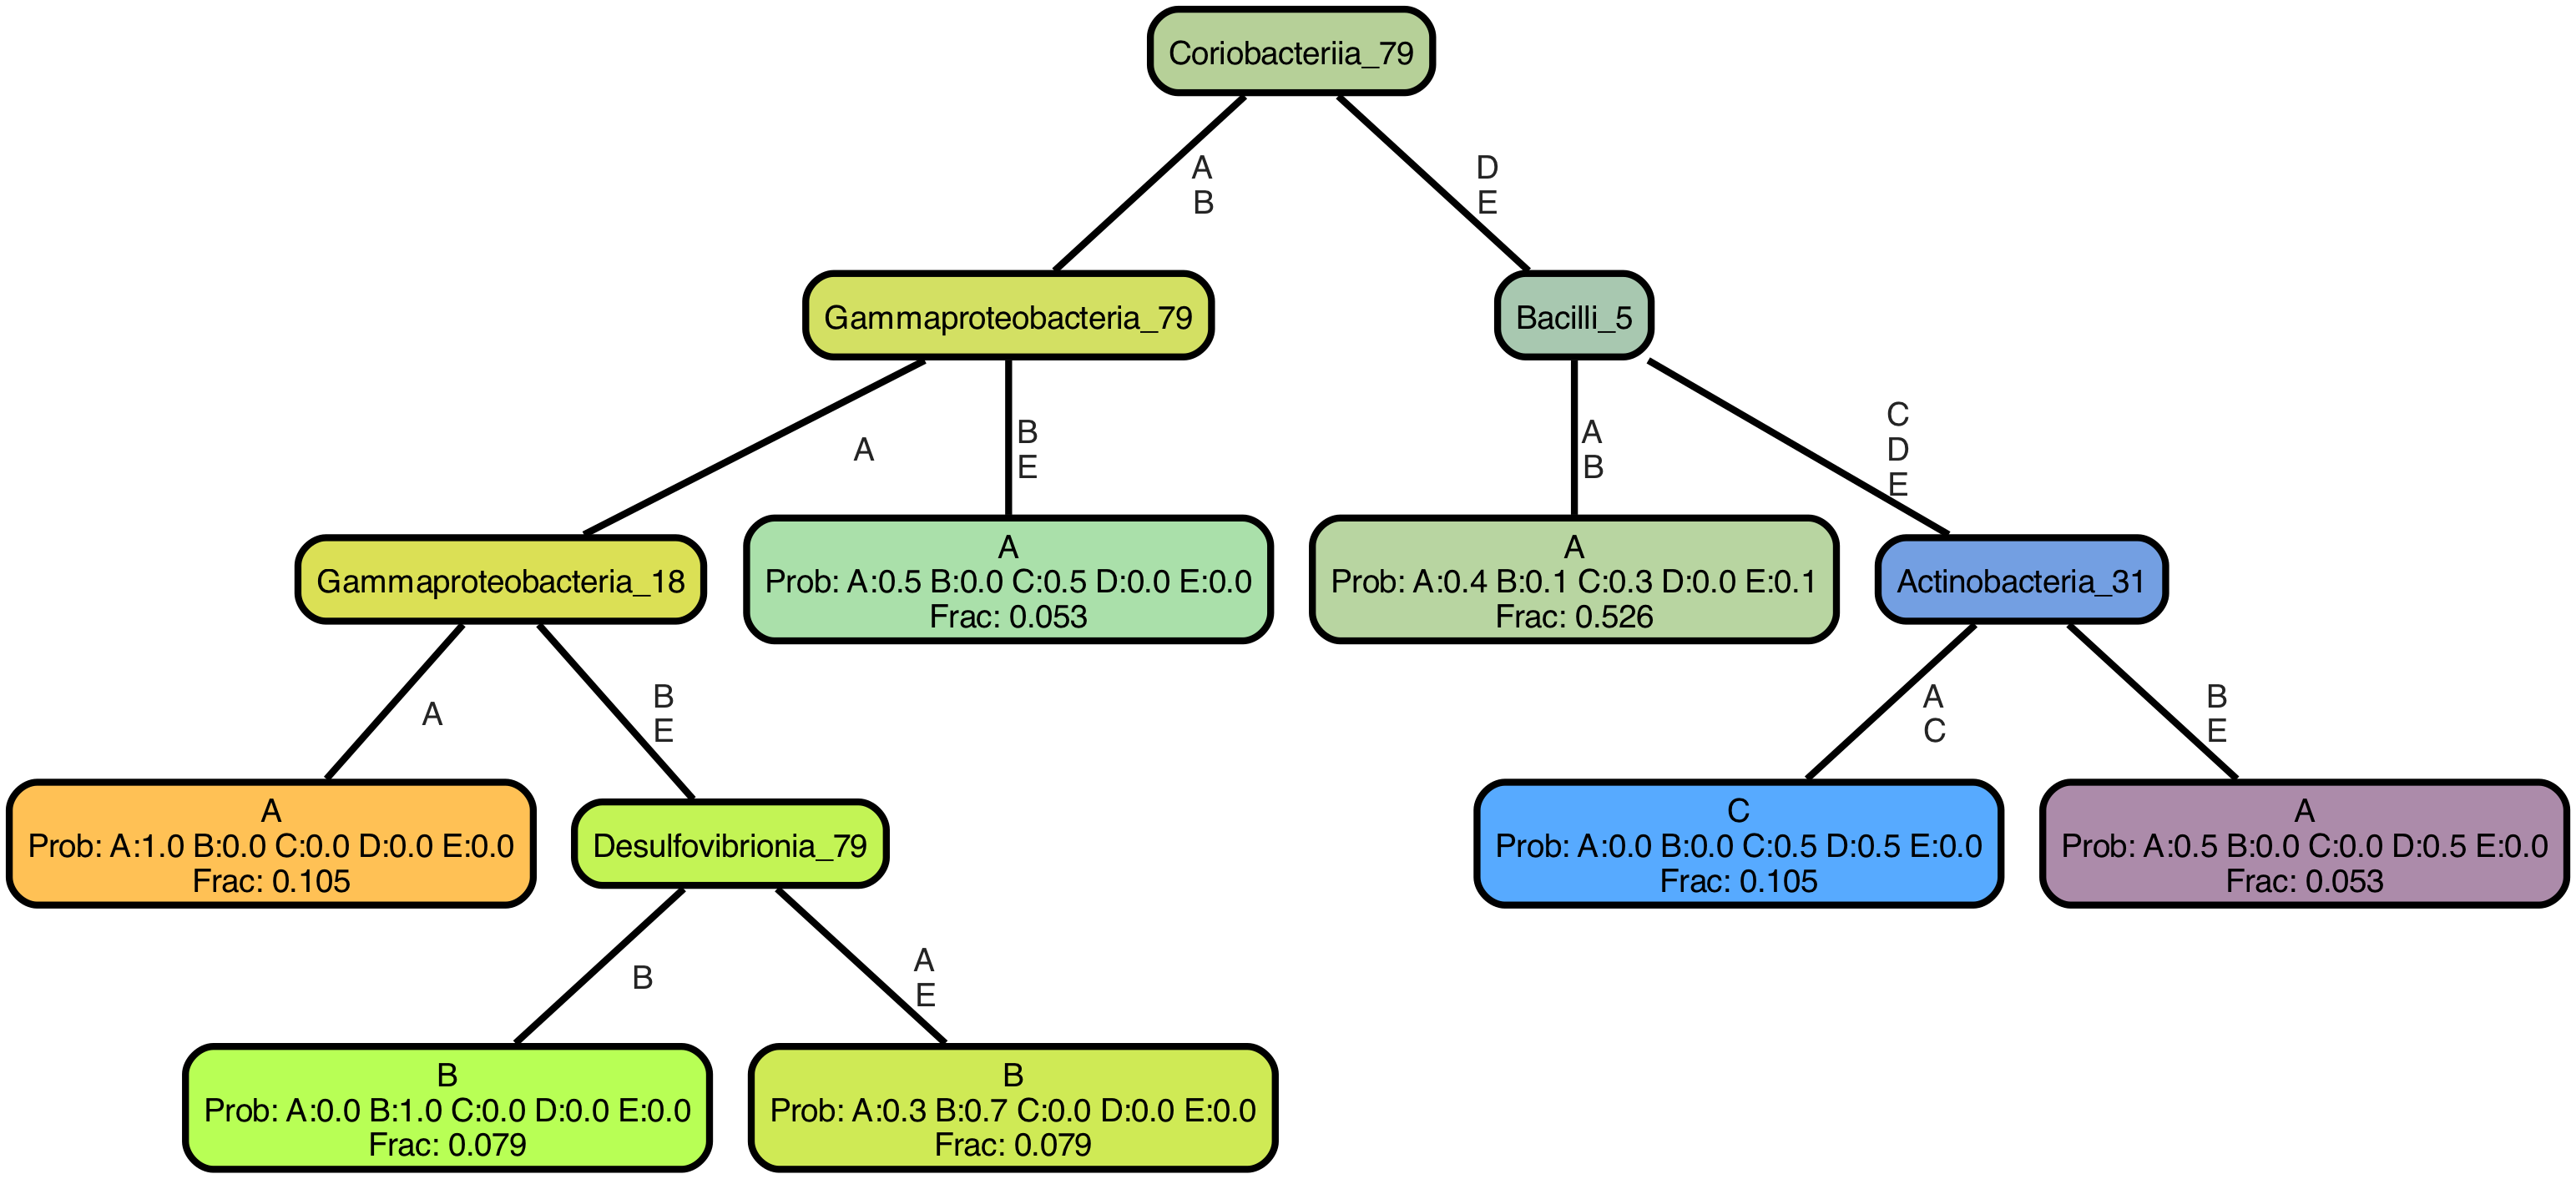

In [18]:
from IPython.display import Image

Image(filename="dotfiles/Gammaproteobacteria_5.png")

# Generate example hypotheses (`LOMAR` coefficients)

Next, we investigate asymmetric (i.e. with a specified source and target) causal interactions between taxa, using `Hypothesis()` methods.

The `causal_constraint` parameter constrains which time points for source can be considered as inputs when computing source to target influences. If causal_constraint is `None`, there are no restrictions. Otherwise, only sources that are at least `causal_constraint` units of time prior to the target may be considered. Note that negative values are allowed, and may be of use if there is possible imprecision in time measurement in the data.


In [12]:
hypothesis = Hypothesis(
    quantizer=quantizer, model_path=outdirname, detailed_labels=True
)

hypothesis.causal_constraint = -2
hypothesis.no_self_loops = False

hypothesis.get(time_start=10, time_end=20)
hypothesis.to_dot("hypothesis_10_20.dot")
hypothesis.hypotheses.sort_values("src")

  6%|▋         | 1/16 [00:00<00:01,  7.86it/s]

100%|██████████| 16/16 [00:02<00:00,  5.63it/s]


,src,tgt,time_tgt,lomar,pvalue
46,Actinobacteria,Negativicutes,10.0,-0.677178,0.000000e+00
1,Actinobacteria,Coriobacteriia,13.0,0.169660,0.000000e+00
44,Actinobacteria,Negativicutes,18.0,-0.038087,8.053522e-43
32,Actinobacteria,Bacteroidia,19.0,0.641613,0.000000e+00
6,Actinobacteria,Verrucomicrobiae,18.0,1.007066,0.000000e+00
8,Actinobacteria,Actinobacteria,10.0,-2.162273,0.000000e+00
45,Actinobacteria,Negativicutes,14.0,-0.007302,0.000000e+00
21,Actinobacteria,Gammaproteobacteria,19.0,-0.664054,0.000000e+00
17,Actinobacteria,Clostridia,19.0,-0.271431,0.000000e+00
43,Alphaproteobacteria,Negativicutes,10.0,2.550000,0.000000e+00


# Forecast microbiome evolution

Next, we forecast abundances from a given initial time point, using the `Forecaster()`.

In [13]:
# forecast from time SW
SW = 29
qnet_orchestrator = QnetOrchestrator(quantizer)
qnet_orchestrator.load_qnet("example_qnet.joblib")
forecaster = Forecaster(qnet_orchestrator)
# can specify an end week or default to the max end week in the data
forecasted_ = forecaster.forecast_data(label_matrix, start_week=SW).assign(
    source="forecasted"
)

In [14]:
DF = forecasted_
SUBJECTS = DF.subject_id.value_counts().index.values
DF

,subject_id,variable,week,value,source
0,1,Actinobacteria,1,0.022015,forecasted
1,10,Actinobacteria,1,0.022015,forecasted
2,11,Actinobacteria,1,0.022015,forecasted
3,12,Actinobacteria,1,0.153790,forecasted
4,14,Actinobacteria,1,0.022015,forecasted
...,...,...,...,...,...
39507,56,unclassified_Bacteria,97,0.000937,forecasted
39508,57,unclassified_Bacteria,97,0.000937,forecasted
39509,7,unclassified_Bacteria,97,0.000937,forecasted
39510,8,unclassified_Bacteria,97,0.000937,forecasted


For comparison, we plot the forecasted vs. actual data (averaged over all subjects):

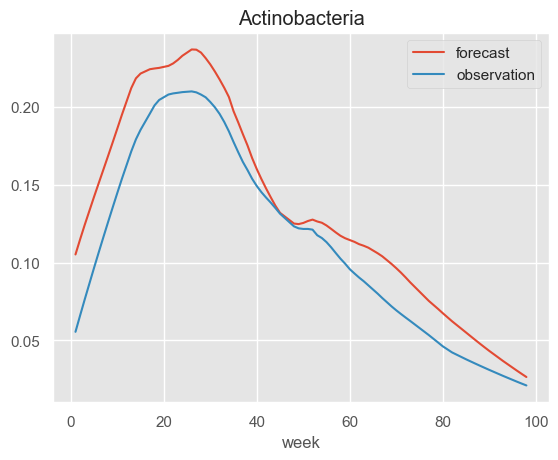

In [15]:
DF_pop = DF.groupby(["variable", "week"]).mean(numeric_only=True).reset_index()
DF_data = data.groupby(["variable", "week"]).mean(numeric_only=True).reset_index()

DF_pop_smooth = qsmooth(
    DF_pop,
    index="week",
    columns="variable",
    normalize=False,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.3,
)

# DF_data_smooth
DF_data_smooth = qsmooth(
    DF_data,
    index="week",
    columns="variable",
    normalize=False,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.3,
)


ax = DF_pop_smooth.Actinobacteria.plot(label="forecast")
DF_data_smooth.Actinobacteria.plot(ax=ax, label="observation")
ax.set_title("Actinobacteria")
ax.legend()

Here is a comparison plot for an individual subject:

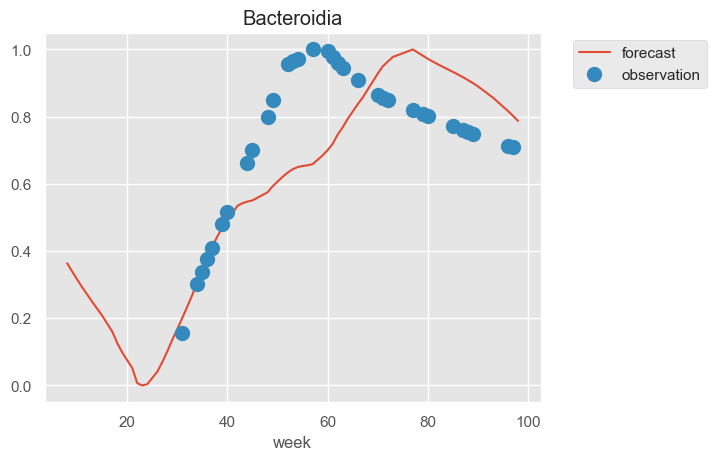

In [16]:
SID = "21"
DF_pop = (
    DF[DF.subject_id == SID]
    .groupby(["variable", "week"])
    .mean(numeric_only=True)
    .reset_index()
)
DF_data = (
    data[DF.subject_id == SID]
    .groupby(["variable", "week"])
    .mean(numeric_only=True)
    .reset_index()
)
DF_pop_smooth = qsmooth(
    DF_pop,
    index="week",
    columns="variable",
    normalize=True,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.4,
)

# DF_data_smooth
DF_data_smooth = qsmooth(
    DF_data,
    index="week",
    columns="variable",
    normalize=True,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.6,
)

var = "Bacteroidia"
ax = DF_pop_smooth[var].plot(label="forecast")
DF_data_smooth[var].plot(ax=ax, style="o", ms=10, label="observation")
ax.set_title("Bacteroidia")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

## Forecast data for a new patient

If we want to forecast the trajectory of a new subject, we just read in their data, quantize, and forecast. 

Here we demonstrate by randomly generating a dummy subject and forecasting from week 29.

,week,variable,value
0,29,Bacilli,0.362657
1,29,Clostridia,0.547037
2,29,Actinobacteria,0.408367
3,29,Gammaproteobacteria,0.879126
4,29,Bacteroidia,0.138898
5,29,Negativicutes,0.660258
6,29,Coriobacteriia,0.835457
7,29,Verrucomicrobiae,0.329231
8,29,Desulfovibrionia,0.465992
9,29,Fusobacteriia,0.908180


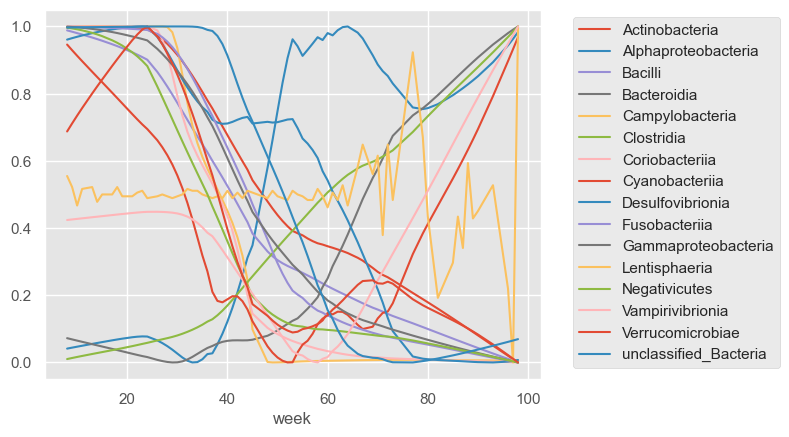

In [17]:
new_subject = pd.DataFrame(
    {
        "week": [SW] * len(TAXA),
        "variable": TAXA,
        "value": np.random.rand(len(TAXA)),
    }
)

new_subject.to_csv("example_data/single_patient_dummy/new_subject.csv", index=None)
new_subject = pd.read_csv("example_data/single_patient_dummy/new_subject.csv")
display(new_subject)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id=12345)
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, start_week=29, subject_id=[12345]
)

df_ = qsmooth(
    new_subject_forecasted.drop("subject_id", axis=1),
    index="week",
    columns="variable",
    interpolate=False,
    alpha=0.5,
    lowess_fraction=0.5,
    normalize=True,
)

ax = df_.plot()
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")